In [8]:
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

In [2]:
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"

engine = sqla.create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
connection = engine.connect()

In [3]:
result = connection.execute(sqla.text("SELECT reltuples::bigint FROM pg_class WHERE relname='datanase'"))
estimated_count = result.scalar()
print(f"Approximate row count: {estimated_count}")

Approximate row count: 235565136


In [12]:
# Query statistics
query = """
SELECT 
    AVG(delay_departure) AS mean, 
    STDDEV(delay_departure) AS std_dev, 
    MIN(delay_departure) AS min_value, 
    MAX(delay_departure) AS max_value, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1,  -- 1st Quartile (25%)
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median, -- Median (50%)
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3  -- 3rd Quartile (75%)
FROM datanase;
"""

result = connection.execute(sqla.text(query)).fetchone()

# Extract values
mean, std_dev, min_value, max_value, q1, median, q3 = result
print(f"Mean: {mean}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}, Q1: {q1}, Median: {median}, Q3: {q3}")

Mean: 138.1400943235141715, Std Dev: 412.158211098320, Min: -170225, Max: 520659, Q1: 4.0, Median: 45.0, Q3: 146.0


In [13]:
# Query statistics
query = """
SELECT 
    AVG(delay_arrival) AS mean, 
    STDDEV(delay_arrival) AS std_dev, 
    MIN(delay_arrival) AS min_value, 
    MAX(delay_arrival) AS max_value, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1,  -- 1st Quartile (25%)
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median, -- Median (50%)
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3  -- 3rd Quartile (75%)
FROM datanase;
"""

result = connection.execute(sqla.text(query)).fetchone()

# Extract values
mean, std_dev, min_value, max_value, q1, median, q3 = result
print(f"Mean: {mean}, Std Dev: {std_dev}, Min: {min_value}, Max: {max_value}, Q1: {q1}, Median: {median}, Q3: {q3}")

Mean: 132.9522403512002853, Std Dev: 497.090915088918, Min: -170383, Max: 3960203, Q1: -4.0, Median: 42.0, Q3: 147.0


In [ ]:
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    COUNT(*) AS row_count, 
    
    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  

FROM datanase
GROUP BY year
ORDER BY year;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)


      year  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0   2014.0   21792638    140.901761       782.195965       -87123   
1   2015.0   21332468    116.212746       422.043395       -88466   
2   2016.0   21365904    142.676588       983.928616       -87991   
3   2017.0   21976359    154.041671       362.448139       -36020   
4   2018.0   22567297    157.051567       357.166114       -23647   
5   2019.0   22351850    127.954879       340.288502       -27108   
6   2020.0   21123945     88.462508       321.909442       -86716   
7   2021.0   22540713    101.203512       311.276038       -86509   
8   2022.0   22480415    136.710739       356.314059       -22368   
9   2023.0   22467606    153.358804       351.680582       -10779   
10  2024.0   23114728    141.385920       365.008272      -170383   

    max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \
0        520659         0.0            42.0       160.0      145.373122   
1        104450      

In [4]:
# SQL query to get statistics for both columns per month & year
query = """
SELECT 
    EXTRACT(YEAR FROM departure_date) AS year, 
    EXTRACT(MONTH FROM departure_date) AS month, 
    COUNT(*) AS row_count, 

    AVG(delay_arrival) AS mean_arrival, 
    STDDEV(delay_arrival) AS std_dev_arrival, 
    MIN(delay_arrival) AS min_arrival, 
    MAX(delay_arrival) AS max_arrival, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_arrival) AS q1_arrival,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_arrival) AS median_arrival,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_arrival) AS q3_arrival,  
    
    AVG(delay_departure) AS mean_departure, 
    STDDEV(delay_departure) AS std_dev_depature, 
    MIN(delay_departure) AS min_departure, 
    MAX(delay_departure) AS max_departure, 
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY delay_departure) AS q1_departure,  
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY delay_departure) AS median_departure,  
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY delay_departure) AS q3_departure  
FROM datanase
GROUP BY year, month
ORDER BY year, month;
"""

df = pd.read_sql(sqla.text(query), connection)

print(df)

       year  month  row_count  mean_arrival  std_dev_arrival  min_arrival  \
0    2014.0    1.0    1900458    119.170084       399.625213       -36003   
1    2014.0    2.0    1734004    118.748212       630.960472       -86595   
2    2014.0    3.0    1868053    129.796352       472.707383       -83157   
3    2014.0    4.0    1824809    113.133004       433.310321       -86349   
4    2014.0    5.0    1839737    131.639121       369.524129       -85531   
..      ...    ...        ...           ...              ...          ...   
127  2024.0    8.0    1862513    122.777168       357.951857        -3466   
128  2024.0    9.0    1935800    146.573065       314.830648        -3636   
129  2024.0   10.0    2031774    139.467159       309.503791        -2740   
130  2024.0   11.0    1861370    161.628514       512.827980      -170383   
131  2024.0   12.0    1983701    114.129460       305.975623       -82489   

     max_arrival  q1_arrival  median_arrival  q3_arrival  mean_departure  \

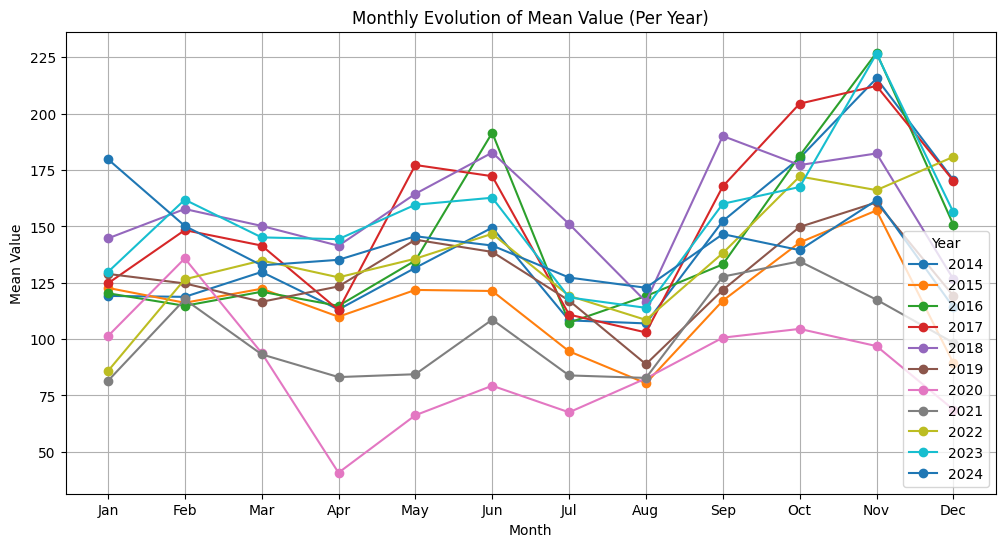

In [ ]:
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)

df["month"] = df["month"].astype(int)
df = df.sort_values(["year", "month"])

plt.figure(figsize=(12, 6))

for year, group in df.groupby("year"):
    plt.plot(group["month"], group["mean_arrival"], marker="o", linestyle="-", label=f"{year}")

plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.xlabel("Month")
plt.ylabel("Mean Value")
plt.title("Monthly Evolution of Mean Value (Per Year)")
plt.legend(title="Year")
plt.grid(True)

plt.show()